<a href="https://colab.research.google.com/github/levhojoyan/thesis/blob/main/Synthetic/synthetic_refactored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader


from IPython import display
import time

%matplotlib inline

In [ ]:
def GenerateSamplesWithGivenFunction(f, left, right, sample_size):
    '''
    returns vector of x's and corresponding vector of f(x) of size (sample_size, 1) each
    '''
    x_s = torch.linspace(left, right, sample_size).unsqueeze(1)
    f_s = f(x_s)
    return x_s, f_s

def GenerateGaussianNoise(mean, std, sample_size):
    '''
    returns vector of iid noises with shape (sample_size, 1)
    '''
    return torch.empty((sample_size, 1)).normal_(mean=mean,std=std)

def custom_function(x):
    return torch.sin(x) + torch.sin(2*x) + 2 * torch.cos(4*x)

sample_size = 1024 * 4
batch_size = 256
epochs = 200
learning_rate = 0.05

pi = 3.14

x_s, real_function_values = GenerateSamplesWithGivenFunction(custom_function, -pi, pi, sample_size=sample_size)
noise_s = GenerateGaussianNoise(0, 0.5, sample_size=sample_size)


f_s = real_function_values + noise_s 

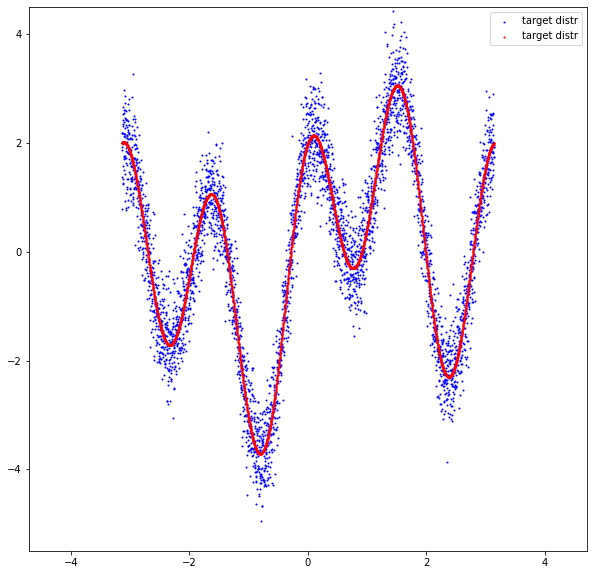

In [ ]:
def plot_2d_dots(x, y, color='blue', label='None'):
    '''
    x, y: tensors of shape (sample_size, 1)
    draws 2d distribution
    '''
    plt.ylim(- 5.5, 4.5)
    plt.xlim(- 1.5 * pi, 1.5 * pi)
    plt.scatter(x, y, s=1, c=color, label=label)

plt.figure(figsize=(10, 10))

plot_2d_dots(x_s, f_s, label='target distr',color='b')
plot_2d_dots(x_s, real_function_values, label='target distr', color='r')


plt.legend()
plt.show()

In [ ]:
f_s.shape

torch.Size([4096, 1])

In [ ]:
batch_size = 512
epochs = 150

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s, f_s, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
X_train_tensor = X_train.float()
X_test_tensor = X_test.float()

y_train_tensor = y_train.squeeze(1).float()
y_test_tensor = y_test.squeeze(1).float()

train_torch = TensorDataset(X_train_tensor, y_train_tensor)
val_torch = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_torch, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_torch, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
X_train_tensor.shape, X_test_tensor.shape

(torch.Size([3276, 1]), torch.Size([820, 1]))

In [ ]:
class Template(nn.Module):
    def __init__(self, input_shape, output_shape=10):
        super(Template, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.convs = nn.Sequential(
                          nn.Linear(self.input_shape, 32),
                          nn.ReLU(),
                          nn.Linear(32, 64),
                          nn.ReLU(),
                          nn.Linear(64, 32),
                          nn.ReLU(),
                          nn.Linear(32, output_shape)
                          )


    def forward(self, x):
        for conv in self.convs:
          x = F.relu(conv(x))

        return x

In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.template = Template(self.input_shape)
        self.conv2 = nn.Linear(self.template.output_shape, 1)

    def forward(self, x):
      x = F.relu(self.template(x))

      return self.conv2(x)

    def count_loss(self, X, y):
        return self.count_mse(X, y)

    def count_mse(self, X, y):
        
        y_pred_functions = self.forward(X)
        
        # print(y_pred_functions.shape, y.shape)
        assert y_pred_functions.shape == y.reshape(-1, 1).shape

        mse = torch.nn.MSELoss()(y_pred_functions, y.reshape(-1, 1))

        return mse

class ModelWithWeighted(nn.Module):
    def __init__(self, input_shape, output_models=16):
        super(ModelWithWeighted, self).__init__()

        self.input_shape = input_shape

        self.conv1 = Template(input_shape) # the simpliest
        self.conv2 = nn.Linear(self.conv1.convs[-1].out_features, output_models) # the simpliest

        self.weights = nn.Parameter(torch.zeros(output_models, requires_grad=True))


    def forward(self, x):
        x = F.relu(self.conv1(x))
        return self.conv2(x)

    def aggregate(self, x):
        norm_weights = F.softmax(self.weights, dim=0)

        y_pred_functions = self.forward(x)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)
        
        return total_pred

    
    def count_loss(self, X, y):
        norm_weights = F.softmax(self.weights, dim=0)

        y_pred_functions = self.forward(X)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)

        # print('kek1')
        # print(y_pred_functions.shape, y.shape)
        # assert y_pred_functions.shape == y.shape
        
        weighted_mse = torch.sum(norm_weights * ((y_pred_functions - y.reshape(-1, 1))**2))

        # print(total_pred.shape, y.shape)
        # print('kek2')

        assert total_pred.shape == y.shape
        # print('kek3')

        mse = torch.nn.MSELoss()(total_pred, y)

        return mse + weighted_mse

    def count_mse(self, X, y):
        norm_weights = F.softmax(self.weights, dim=0)

        y_pred_functions = self.forward(X)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)
        
        assert total_pred.shape == y.shape

        mse = torch.nn.MSELoss()(total_pred, y)

        return mse

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
torch.manual_seed(0)

In [ ]:
def DrawSampleAndLearned(x_s, f_s, pred):
  '''
  draws in 2d f_s(x_s) and pred(x_s)
  '''
  plt.figure(figsize=(10, 10))
  plot_2d_dots(x_s, f_s, color='r', label='target distr')
  plot_2d_dots(x_s, pred, color='b', label='train distr')
  plt.legend()
  plt.show() 


In [ ]:
def train_and_get_log_Q():
    learning_rate = 0.01
    model2 = ModelWithWeighted(X_train.shape[1])
    optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    log_weights = {}

    log_weights['train_losses'] = []
    log_weights['test_losses'] = []

    epochs = 150

    for i, epoch in enumerate(range(epochs)):
        for x_batch, y_batch in train_dataloader:
            loss = model2.count_loss(x_batch, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        with torch.no_grad():
            test_mse = model2.count_mse(X_test_tensor, y_test_tensor).item()
            train_mse = model2.count_mse(X_train_tensor, y_train_tensor).item()

            log_weights['train_losses'].append(train_mse)
            log_weights['test_losses'].append(test_mse)

        lr = get_lr(optimizer)

    #     print(
    #         f"[{epoch}/{epochs}]\t Training loss: {train_mse:8.4f}\t Validation loss: {test_mse:8.4f}\t Learning rate: {lr:8.4f}"
    #     )

    # plt.plot(log_weights['test_losses'][20:], c='b', label='test')
    # plt.plot(log_weights['train_losses'][20:], c='r', label='train')
    # plt.legend()
    # plt.show()

    return model2, log_weights['test_losses']

model2, log_weights = train_and_get_log_Q()

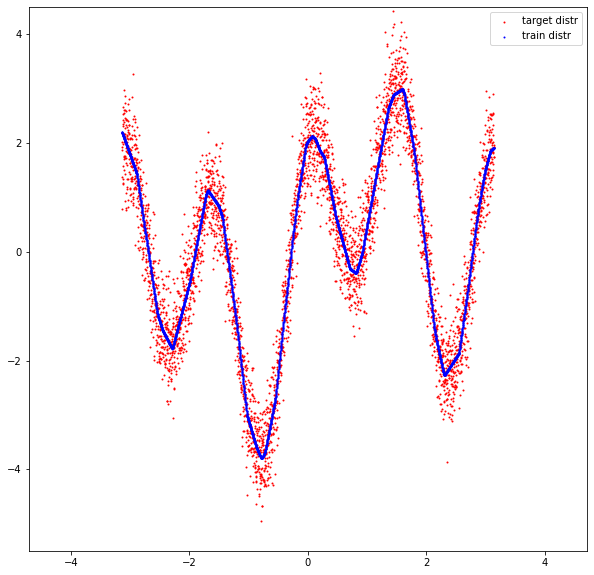

In [ ]:
pred = model2.aggregate(x_s).detach().numpy()
DrawSampleAndLearned(x_s, f_s, pred)

In [ ]:
def train_and_get_log_default():
    learning_rate = 0.01
    model = Model(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    log_original = {}

    log_original['train_losses'] = []
    log_original['test_losses'] = []

    epochs = 150

    for i, epoch in enumerate(range(epochs)):
        for x_batch, y_batch in train_dataloader:
            loss = model.count_loss(x_batch, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()


        with torch.no_grad():
            test_mse = model.count_mse(X_test_tensor, y_test_tensor).item()
            train_mse = model.count_mse(X_train_tensor, y_train_tensor).item()

            log_original['train_losses'].append(train_mse)
            log_original['test_losses'].append(test_mse)

        lr = get_lr(optimizer)

    #     print(
    #         f"[{epoch}/{epochs}]\t Training loss: {train_mse:8.4f}\t Validation loss: {test_mse:8.4f}\t Learning rate: {lr:8.4f}"
    #     )

    # plt.plot(log_original['test_losses'][20:], c='b', label='test')
    # plt.plot(log_original['train_losses'][20:], c='r', label='train')
    # plt.legend()
    # plt.show()
    return model, log_original['test_losses']

model, _ = train_and_get_log_default()

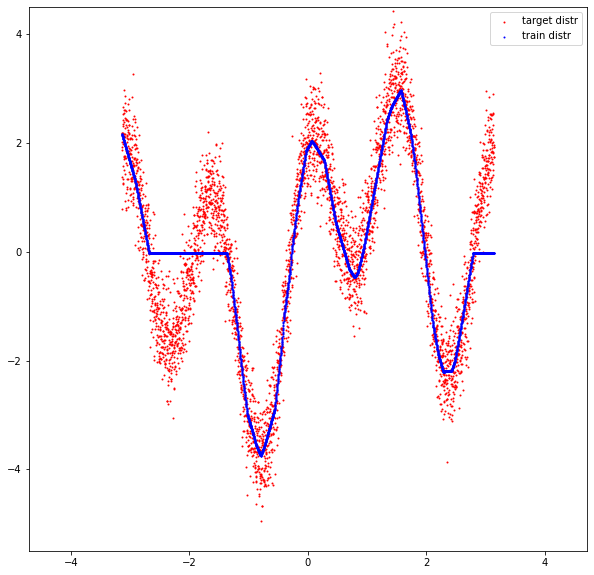

In [ ]:
pred = model(x_s).detach().numpy()
DrawSampleAndLearned(x_s, f_s, pred)

In [ ]:
model, model2

(Model(
   (template): Template(
     (convs): Sequential(
       (0): Linear(in_features=1, out_features=32, bias=True)
       (1): ReLU()
       (2): Linear(in_features=32, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=32, bias=True)
       (5): ReLU()
       (6): Linear(in_features=32, out_features=10, bias=True)
     )
   )
   (conv2): Linear(in_features=10, out_features=1, bias=True)
 ), ModelWithWeighted(
   (conv1): Template(
     (convs): Sequential(
       (0): Linear(in_features=1, out_features=32, bias=True)
       (1): ReLU()
       (2): Linear(in_features=32, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=32, bias=True)
       (5): ReLU()
       (6): Linear(in_features=32, out_features=10, bias=True)
     )
   )
   (conv2): Linear(in_features=10, out_features=5, bias=True)
 ))

In [ ]:
torch.manual_seed(0)
Q_story = []
for _ in tqdm(range(10)):
    _, l = train_and_get_log_Q()
    Q_story.append(l[-1])

np.mean(Q_story), np.std(Q_story)

  0%|          | 0/10 [00:00<?, ?it/s]

(0.34344545304775237, 0.15087957755739245)

In [ ]:
torch.manual_seed(0)
story = []
for _ in tqdm(range(10)):
    _, l = train_and_get_log_default()
    story.append(l[-1])

np.mean(story), np.std(story)

  0%|          | 0/10 [00:00<?, ?it/s]

(0.37784760296344755, 0.2550412647382361)

In [ ]:
Q_story

[0.6683891415596008,
 1.0639703273773193,
 0.2595648467540741,
 0.25783872604370117,
 0.6409124135971069,
 0.25303134322166443,
 0.2548246681690216,
 0.2583623230457306,
 0.2538004517555237,
 0.26155415177345276]

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(log_original['test_losses'], c='b', label='original')
plt.plot(log_weights['test_losses'], c='r', label='Q-aggregation')
plt.ylabel('Risk on test data')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(log_original['test_losses'][100:], c='b', label='original')
plt.plot(log_weights['test_losses'][100:], c='r', label='Q-aggregation')
plt.ylabel('Risk on test data')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
plt.plot(log_original['test_losses'][80:150], c='b', label='original')